# LiberTEM-panel-ui demo

This notebook demonstrates how to use the features of `LiberTEM-panel-ui` for interactive offline data processing with LiberTEM.

This demo displays best in `JupyterLab` as it requires the full width of the browser window. If you are using a classic Notebook you can expand the width by calling `libertem_ui.utils.notebook_tools.notebook_fullwidth()` (uncomment the next cell):

In [ ]:
# from libertem_ui.utils.notebook_tools import notebook_fullwidth
# notebook_fullwidth()

In [ ]:
import pathlib
import numpy as np

## Create LiberTEM resources and data

The GUI tools work in combination with a LiberTEM `Context` object `DataSet` object, which describe how LiberTEM will carry out computations and load data, respectively.

Here we will create a `Context` backed by 4 Dask workers, and an artificial dataset `DataSet` backed by a *numpy* array file on disk (`.npy` file).

In [ ]:
import libertem.api as lt

In [ ]:
ctx = lt.Context.make_with(cpus=4)

We can generate some test data using an included util function, or load it from disk if already present:

In [ ]:
data_path = pathlib.Path('test_data.npy')

In [ ]:
if not data_path.is_file():
    from libertem_ui.utils.data import demo_dataset
    np.save(data_path, demo_dataset())

In [ ]:
ds = ctx.load('npy', path=data_path)

These data have the following shape:

In [ ]:
ds.shape

## Standalone analyses

The simplest way to get started with `LiberTEM-panel-ui` is to launch a standalone analysis window using a `ctx` and `ds`:

In [ ]:
from libertem_ui.windows.imaging import VirtualDetectorWindow

In [ ]:
detector_window = VirtualDetectorWindow.using(ctx, ds)

Once created, the window must be displayed using the `.layout()` method as the final line of a cell:

In [ ]:
detector_window.layout()

From this window we can run all standard virtual detector analyses on this dataset. The mode can be selected from the buttons on the left, and the analysis run using the Run/Stop buttons at the top of the pane.

The detector widget is draggable to set the centrepoint, and the orange cursor in the navigation figure is draggable to select which frame to display in the signal figure.

Both figures can have their display options adjusted by bringing up their floating controls panel (option icon in the figure toolbar). The navigation panel also supports drawing a region of interest (ROI) using the drawing tools in the figure toolbar.

## Linked windows

It is possible to link two or more analysis windows such that they can share results (for display purposes or for more complex analyses). The dataset and context are common to both windows.

In [ ]:
from libertem_ui.windows.imaging import FrameImagingWindow

In [ ]:
imaging_window = FrameImagingWindow.linked_to(detector_window)
imaging_window.layout()

When running analysis in the `FrameImagingWindow` you have the option to display its results in the `VirtualDetectorWindow` by clicking on the `Display` button in the header (and vice versa).

## Exporting / Using results

Results generated by a window can be stored in its `ResultsManager`, which is also shared between windows where these have been linked. The `.results_manager` property of a window allows us to query the manager for existing results, as well as display an interactive results browser where we can search for and preview results.

In [ ]:
imaging_window.results_manager.layout()

Results can be previewed using the 🔍 icon, and deleted using the ✕ button. The preview page for each results contains a view of the metadata for that result, as well as a download button to save the result to disk.

To access a given result you need to access it through its `ident` string, displayed in the manager table and on the preview page:

In [ ]:
try:
    ident: str
    rc = imaging_window.results_manager.get_result_container(ident)
except NameError:
    # Result doesn't exist yet!
    pass

The object returned is a `ResultContainer` which holds metadata and a `.show()` method to preview the result in a standalone cell. The actual result object can be found on the `.data` property.

## `UIContext`, a window manager for analyses

The `UIContext` is a system to allow dynamic creation and deletion of analysis windows in `libertem_ui`, and execute their analyses in parallel where this is supported. Windows created in a `UIContext` are automatically linked together and share results.

In [ ]:
from libertem_ui.api import UIContext

In [ ]:
ui_context = UIContext.for_offline(ctx, ds)
ui_context.layout()

At the bottom of the cell / layout there is an `Add window` menu which allows you to add windows to the `UIContext` layout.

Most windows also have a `Remove` button to remove them from the layout. Results created by a remove window remain available unless explicitly deleted in the `ui_context.results_manager`.

The `UIContext` also has an inbuilt log window to report information about the analyses being run, this can be displayed by pressing the `Logs` button below the progress bar.

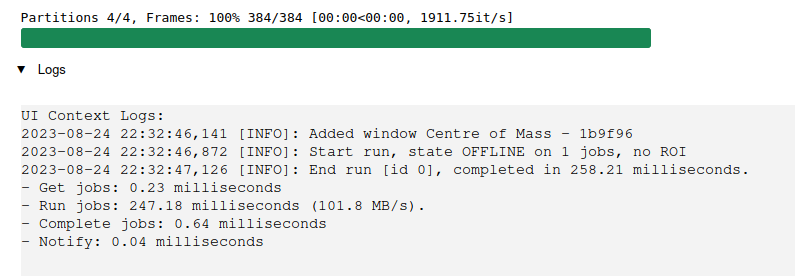

Pressing `Run all` queries all windows for any analyses they are ready to run, and will run all that are available in parallel. Some windows require they are run alone and so will not respond to the `Run all` button press. To disable a window from running under `Run all`, untick the `Activate` checkbox in the header.

Windows can be collapsed using the `▼` button at the left of the header. Collapsed windows can still run, and must be de-activated if you need to save on computation.